In [ ]:
# Install the necessary libraries
!pip install PyPortfolioOpt #Library to perform portfolio optimization
!pip install yfinance #Library to download financial data
!pip install forex-python #Library to download forex data

## Comparison of Modern Portfolio Theory returns and risk models on given set of stocks
The idea is to compare the different portfolios that are created as a result of different combinations of returns and risk models.
There are many models available for both returns and risk.

For returns, I will look at the following:
 - Mean historical returns
 - Exponentially weighted mean of historical returns
 - Returns based on CAPM

For risk models, I will look at the following:
 - Sample covariance
 - Ledoit-Wolf with 3 different shrinkage targets
    - Constant variance
    - Single factor
    - Constant correlation

This results in 3x4 = 12 different portfolios to be compared.








### Step 1: Pick a portfolio to balance
As a starting point I have chosen the following stocks inspired by my friend's portfolio:

- Frontline (FRO.OL): NOK (listed on the Oslo Stock Exchange)
- Nordea Bank Abp (NDA-FI.HE): EUR (listed on the Helsinki Stock Exchange)
- BAWAG Group AG (BG.VI): EUR (listed on the Vienna Stock Exchange)
- CaixaBank (CABK.MC): EUR (listed on the Madrid Stock Exchange)
- Danske Bank (DANSKE.CO): DKK (listed on the Copenhagen Stock Exchange)
- McDonald’s (MCD): USD (listed on the NYSE)


### Step 2: Read in price data

In [1]:
import pandas as pd
import yfinance as yf

In [4]:
# Ticker symbols for the chosen stocks
tickers = ['FRO.OL', 'NDA-FI.HE', 'BG.VI', 'CABK.MC', 'DANSKE.CO', 'MCD']

# Download historical data for the specified tickers from Yahoo Finance
stock_data = yf.download(tickers, start='2008-01-01', end='2024-09-10')

# Extract the adjusted close prices, which we are interested in for the analysis
stock_prices = stock_data['Adj Close'].reset_index()
stock_prices.columns.name = None
stock_prices.set_index('Date', drop = True, inplace = True)
display(stock_prices.tail()) #Display the 5 latest prices for the chosen time period

[                       0%                       ]

[*********************100%***********************]  6 of 6 completed


,BG.VI,CABK.MC,DANSKE.CO,FRO.OL,MCD,NDA-FI.HE
Date,,,,,,
2024-09-03 00:00:00+00:00,67.599998,5.310,208.399994,243.567825,285.519989,10.615
2024-09-04 00:00:00+00:00,68.500000,5.288,210.399994,241.273773,288.029999,10.515
2024-09-05 00:00:00+00:00,70.900002,5.374,209.699997,238.082062,287.970001,10.685
2024-09-06 00:00:00+00:00,69.099998,5.318,207.699997,241.572998,289.510010,10.435
2024-09-09 00:00:00+00:00,69.500000,5.428,206.600006,236.785431,291.290009,10.585


### Step 3: Calculate expected returns and portfolio variance with different models

In [7]:
from pypfopt import EfficientFrontier 
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import BlackLittermanModel

# Calculate expected returns and sample covariance
mu_mean = expected_returns.mean_historical_return(stock_prices) # Annualised mean historical return
mu_ema = expected_returns.ema_historical_return(stock_prices) # Exponentially weighted mean
mu_capm = expected_returns.capm_return(stock_prices) # Returns calculated based on CAPM

# Set up different risk models
S_sample_cov = risk_models.sample_cov(stock_prices) # Sample covariance
S_LW_cv = risk_models.CovarianceShrinkage(stock_prices).ledoit_wolf(shrinkage_target='constant_variance') # Ledoit-Wolf with constant variance as shrinkage target
S_LW_sf = risk_models.CovarianceShrinkage(stock_prices).ledoit_wolf(shrinkage_target='single_factor') # Ledoit-Wolf with single factor(identity matrix) as shrinkage target
S_LW_cc = risk_models.CovarianceShrinkage(stock_prices).ledoit_wolf(shrinkage_target='constant_correlation') # Ledoit-Wolf with constant correlation as shrinkage target

/usr/local/python/3.12.1/lib/python3.12/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")
/usr/local/python/3.12.1/lib/python3.12/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")
/usr/local/python/3.12.1/lib/python3.12/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-lea

### Step 4: Optimize for maximal Sharpe ratio on all combinations of returns and risk models

- Portfolio 1 is mean historical returns X sample covariance
- Portfolio 2 is mean historical returns X Ledoit-Wolf constant variance
- Portfolio 3 is mean historical returns X Ledoit-Wolf single factor
- Portfolio 4 is mean historical returns X Ledoit-Wolf constant correlation
- Portfolio 5 is exponentially weighted mean of historical returns X sample covariance
- Portfolio 6 is exponentially weighted mean of historical returns X Ledoit-Wolf constant variance
- Portfolio 7 is exponentially weighted mean of historical returns X Ledoit-Wolf single factor
- Portfolio 8 is exponentially weighted mean of historical returns X Ledoit-Wolf constant correlation
- Portfolio 9 is CAPM X sample covariance
- Portfolio 10 is CAPM X Ledoit-Wolf constant variance
- Portfolio 11 is CAPM X Ledoit-Wolf single factor
- Portfolio 12 is CAPM X Ledoit-Wolf constant correlation

#### ef1

In [9]:
# Optimize for maximal Sharpe ratio
ef1 = EfficientFrontier(mu_mean, S_sample_cov) #Add constraints: ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.1)) #Max 10% on each weight.
# ef1.add_objective(objective_functions.L2_reg, gamma=1) #Reduce zero-weights by adding penalty on small weights with a L2-regularization term
ef1_raw_weights = ef1.max_sharpe()
ef1_cleaned_weights = ef1.clean_weights()
# ef1.save_weights_to_file("weights_apmc_LedoitWolf.csv")  # saves to file
print(ef1_cleaned_weights)
ef1.portfolio_performance(verbose=True)

OrderedDict({'BG.VI': 0.15728, 'CABK.MC': 0.0, 'DANSKE.CO': 0.0, 'FRO.OL': 0.0, 'MCD': 0.84272, 'NDA-FI.HE': 0.0})
Expected annual return: 12.8%
Annual volatility: 18.9%
Sharpe Ratio: 0.57


(0.12809974129527324, 0.1892478581368185, 0.5712072113234778)

#### ef2

In [10]:
# Optimize for maximal Sharpe ratio
ef2 = EfficientFrontier(mu_mean, S_LW_cv) #Add constraints: ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.1)) #Max 10% on each weight.
# ef2.add_objective(objective_functions.L2_reg, gamma=1) #Reduce zero-weights by adding penalty on small weights with a L2-regularization term
ef2_raw_weights = ef2.max_sharpe()
ef2_cleaned_weights = ef2.clean_weights()
# ef2.save_weights_to_file("weights_apmc_LedoitWolf.csv")  # saves to file
print(ef2_cleaned_weights)
ef2.portfolio_performance(verbose=True)

OrderedDict({'BG.VI': 0.43154, 'CABK.MC': 0.0, 'DANSKE.CO': 0.0, 'FRO.OL': 0.0, 'MCD': 0.56846, 'NDA-FI.HE': 0.0})
Expected annual return: 12.6%
Annual volatility: 15.9%
Sharpe Ratio: 0.66


(0.125623423092053, 0.15889621059002754, 0.6647321713956721)

#### ef5

In [11]:
# Optimize for maximal Sharpe ratio
ef5 = EfficientFrontier(mu_ema, S_sample_cov) #Add constraints: ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.1)) #Max 10% on each weight.
# ef5.add_objective(objective_functions.L2_reg, gamma=1) #Reduce zero-weights by adding penalty on small weights with a L2-regularization term
ef5_raw_weights = ef5.max_sharpe()
ef5_cleaned_weights = ef5.clean_weights()
# ef5.save_weights_to_file("weights_apmc_LedoitWolf.csv")  # saves to file
print(ef5_cleaned_weights)
ef5.portfolio_performance(verbose=True)

OrderedDict({'BG.VI': 0.49195, 'CABK.MC': 0.32487, 'DANSKE.CO': 0.09466, 'FRO.OL': 0.07031, 'MCD': 0.01822, 'NDA-FI.HE': 0.0})
Expected annual return: 47.5%
Annual volatility: 26.7%
Sharpe Ratio: 1.70


(0.47512207643265914, 0.26705556704914013, 1.7042223888518055)

#### ef6

In [12]:
# Optimize for maximal Sharpe ratio
ef6 = EfficientFrontier(mu_ema, S_LW_cv) #Add constraints: ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.1)) #Max 10% on each weight.
# ef6.add_objective(objective_functions.L2_reg, gamma=1) #Reduce zero-weights by adding penalty on small weights with a L2-regularization term
ef6_raw_weights = ef6.max_sharpe()
ef6_cleaned_weights = ef6.clean_weights()
# ef6.save_weights_to_file("weights_apmc_LedoitWolf.csv")  # saves to file
print(ef6_cleaned_weights)
ef6.portfolio_performance(verbose=True)

OrderedDict({'BG.VI': 0.79132, 'CABK.MC': 0.13713, 'DANSKE.CO': 0.03322, 'FRO.OL': 0.03832, 'MCD': 0.0, 'NDA-FI.HE': 0.0})
Expected annual return: 50.3%
Annual volatility: 19.7%
Sharpe Ratio: 2.45


(0.5027497055083142, 0.19682916179681115, 2.45263304025377)

#### ef9

In [13]:
# Optimize for maximal Sharpe ratio
ef9 = EfficientFrontier(mu_capm, S_sample_cov) #Add constraints: ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.1)) #Max 10% on each weight.
# ef9.add_objective(objective_functions.L2_reg, gamma=1) #Reduce zero-weights by adding penalty on small weights with a L2-regularization term
ef9_raw_weights = ef9.max_sharpe()
ef9_cleaned_weights = ef9.clean_weights()
# ef9.save_weights_to_file("weights_apmc_LedoitWolf.csv")  # saves to file
print(ef9_cleaned_weights)
ef9.portfolio_performance(verbose=True)

OrderedDict({'BG.VI': 0.16156, 'CABK.MC': 0.1454, 'DANSKE.CO': 0.17201, 'FRO.OL': 0.19282, 'MCD': 0.15008, 'NDA-FI.HE': 0.17814})
Expected annual return: 8.2%
Annual volatility: 23.9%
Sharpe Ratio: 0.26


(0.08240183067822102, 0.23918840748026424, 0.2608898622453928)

#### ef10

In [14]:
# Optimize for maximal Sharpe ratio
ef10 = EfficientFrontier(mu_capm, S_LW_cv) #Add constraints: ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.1)) #Max 10% on each weight.
# ef10.add_objective(objective_functions.L2_reg, gamma=1) #Reduce zero-weights by adding penalty on small weights with a L2-regularization term
ef10_raw_weights = ef10.max_sharpe()
ef10_cleaned_weights = ef10.clean_weights()
# ef10.save_weights_to_file("weights_apmc_LedoitWolf.csv")  # saves to file
print(ef10_cleaned_weights)
ef10.portfolio_performance(verbose=True)

OrderedDict({'BG.VI': 0.56016, 'CABK.MC': 0.05185, 'DANSKE.CO': 0.09533, 'FRO.OL': 0.13141, 'MCD': 0.06468, 'NDA-FI.HE': 0.09658})
Expected annual return: 8.0%
Annual volatility: 18.9%
Sharpe Ratio: 0.32


(0.07992821311827386, 0.18940587305640275, 0.3164010289186121)

In [16]:
display(ef10_cleaned_weights)

OrderedDict([('BG.VI', 0.56016),
             ('CABK.MC', 0.05185),
             ('DANSKE.CO', 0.09533),
             ('FRO.OL', 0.13141),
             ('MCD', 0.06468),
             ('NDA-FI.HE', 0.09658)])

In [17]:
portfolios = {
    'Portfolio 1': [2000, 1500, 2500, 1000, 1500, 1500],
    'Portfolio 2': [1800, 1600, 2400, 1200, 1400, 1600],
    'Portfolio 3': [2200, 1300, 2300, 1100, 1700, 1400],
    'Portfolio 4': [2100, 1400, 2200, 1300, 1600, 1400],
    'Portfolio 5': [1900, 1700, 2100, 1200, 1500, 1600],
    'Portfolio 6': [2000, 1600, 2000, 1400, 1400, 1600]
}

In [18]:
display(portfolios)

{'Portfolio 1': [2000, 1500, 2500, 1000, 1500, 1500],
 'Portfolio 2': [1800, 1600, 2400, 1200, 1400, 1600],
 'Portfolio 3': [2200, 1300, 2300, 1100, 1700, 1400],
 'Portfolio 4': [2100, 1400, 2200, 1300, 1600, 1400],
 'Portfolio 5': [1900, 1700, 2100, 1200, 1500, 1600],
 'Portfolio 6': [2000, 1600, 2000, 1400, 1400, 1600]}

### Step 5: Compare the different portfolios

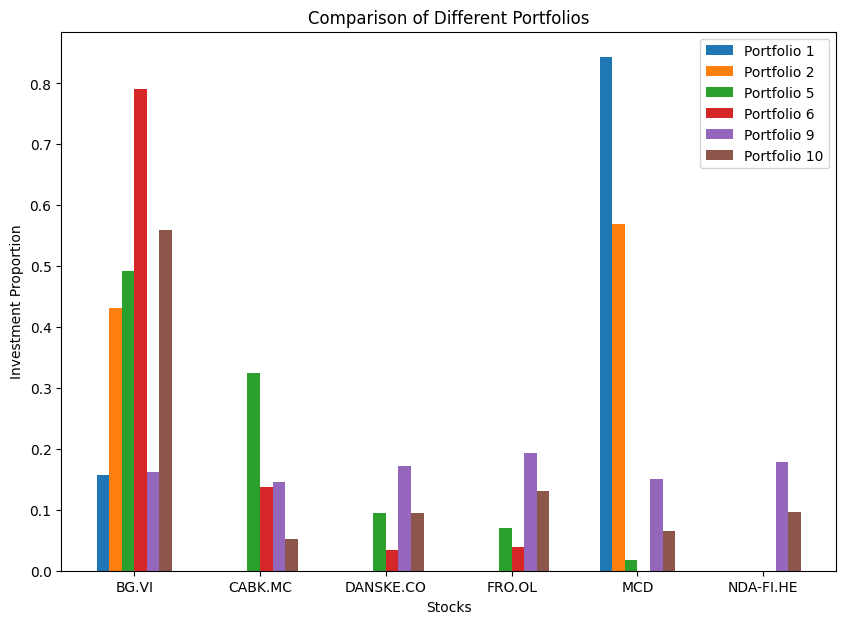

In [20]:
import matplotlib.pyplot as plt
from collections import OrderedDict

portfolios = {
    'Portfolio 1': ef1_cleaned_weights,
    'Portfolio 2': ef2_cleaned_weights,
    'Portfolio 5': ef5_cleaned_weights,
    'Portfolio 6': ef6_cleaned_weights,
    'Portfolio 9': ef9_cleaned_weights,
    'Portfolio 10': ef10_cleaned_weights
}

# Stock labels
stocks = list(ef1_cleaned_weights.keys())

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Plot each portfolio as a bar chart
for i, (portfolio_name, values) in enumerate(portfolios.items()):
    ax.bar([x + i*0.1 for x in range(len(stocks))], values.values(), width=0.1, label=portfolio_name)

# Set the x-axis labels
ax.set_xticks([x + 0.25 for x in range(len(stocks))])
ax.set_xticklabels(stocks)

# Set the labels and title
ax.set_xlabel('Stocks')
ax.set_ylabel('Investment Proportion')
ax.set_title('Comparison of Different Portfolios')

# Add a legend
ax.legend()

# Show the plot
plt.show()
